In [ ]:
Capstone Project - The Battle of Neighborhoods

Introduction


I'm a resident of New York and always wanted to explore the restaurant business around New York. I am interested to know which cuisine based restaurant would be successful and in which neighbourhood.

Data


New York City data:
        https://cocl.us/new_york_dataset
            
Neighbourhood Exploration API:
         Fousquare API
        
Visualising the boundaries:
         https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
            
            


Approach


Collect the new york city data from https://cocl.us/new_york_dataset
Using FourSquare API we will find all venues for each neighborhood.
Find rating , tips and like count for each Resturants using FourSquare API.
Using rating for each resturant type, we will sort that data.
Visualize the Ranking of neighborhoods using folium library(python)


In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#import geocoder


# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [4]:
import time

In [5]:
os.environ['CLIENT_ID']='J35SCFKMV50ASNIYVGRDBW0MWDXLVF3OPH02ZSY3TUVA1FUE'
os.environ['CLIENT_SECRET']='SVH00YZHMK0VC01C1ZWHOJZ30LEIXR25LUQXNJLIBWKXW2UF'

In [14]:
os.environ

environ{'LC_ALL': 'C.UTF-8',
        'HADOOP_HOME': '/home/jupyterlab/hadoop-2.7.3',
        'LANG': 'C.UTF-8',
        'HOSTNAME': 'a2d8aae6ce42',
        'OLDPWD': '/home/jupyterlab',
        'SPARK_PACKAGE': 'spark-2.3.1-bin-without-hadoop',
        'NB_UID': '1000',
        'SPARK_VERSION': '2.3.1',
        'JAVA_HOME': '/usr/jdk1.8.0_131',
        'CONDA_DIR': '/home/jupyterlab/conda',
        'PYTHONIOENCODING': 'UTF-8',
        'PROJ_LIB': '/home/jupyterlab/conda/share/proj',
        'USER': 'jupyterlab',
        'PYTHONHASHSEED': '0',
        'PWD': '/resources',
        'HOME': '/home/jupyterlab',
        'TUTORIALS_GIT_URL': 'https://github.com/cognitive-class/jupyterlab-tutorials.git',
        'SHOWCASE_URL': 'https://showcase.cognitiveclass.ai',
        'ANACONDA_VERSION': '5.3.1',
        '_SPARK_CMD_USAGE': 'Usage: ./bin/pyspark [options]',
        'HADOOP_CONF_DIR': '/home/jupyterlab/hadoop-2.7.3/etc/hadoop',
        'SPARK_SCALA_VERSION': '2.12',
        'SPARK_HOME': '

In [6]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [7]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
    CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    #print(url)
    # get all the data
    results = requests.get(url).json()
    #print(results)
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [21]:
#get_venues(40.894705,-73.847201)

In [8]:
def get_venue_details(venue_id):
        
    CLIENT_ID = os.environ['CLIENT_ID'] # your Foursquare ID
    CLIENT_SECRET = os.environ['CLIENT_SECRET'] # your Foursquare Secret
    VERSION = '20190605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET,
            VERSION)
    
    #print(url)
    # get all the data
    try:
        results = requests.get(url).json()
    except:
        results=[]
        raise 
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [9]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                             'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [10]:
new_york_data=get_new_york_data()


In [11]:
new_york_data.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape


(306, 4)

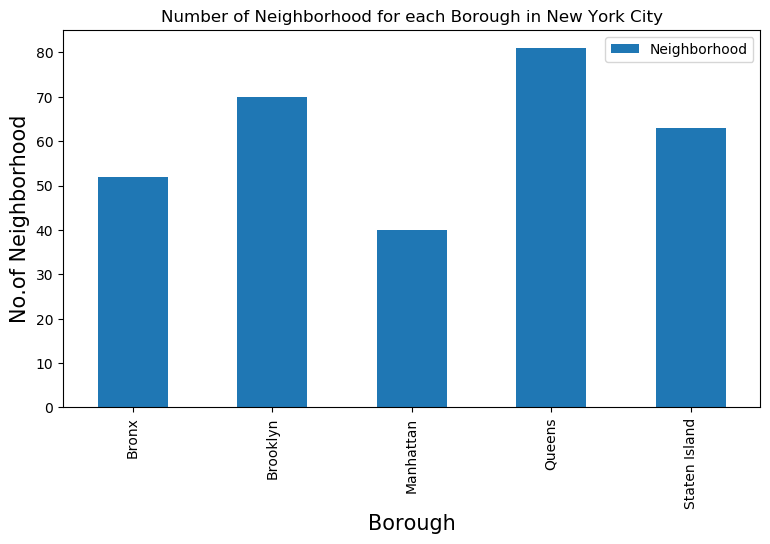

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [12]:
new_york_data.groupby('Borough')['Neighborhood'].count()

Borough
Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63
Name: Neighborhood, dtype: int64

In [12]:
column_names=['Borough', 'Neighborhood', 'Category', 'ID','Name']
rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood,  Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    resturants=venues[venues['Category'].str.contains('Restaurant')]   
    print('(',count,'/',len(new_york_data),')', 'Resturants in '+Neighborhood+', '+Borough+':'+str(len(resturants)))
    #print(resturants)
    #break
    time.sleep(1)
    for resturant_detail in resturants.values.tolist():
        category, id, name =resturant_detail
        rest_ny = rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood,  
                                                'Category' : category,  
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Resturants in Wakefield, Bronx:11
( 2 / 306 ) Resturants in Co-op City, Bronx:13
( 3 / 306 ) Resturants in Eastchester, Bronx:13
( 4 / 306 ) Resturants in Fieldston, Bronx:6
( 5 / 306 ) Resturants in Riverdale, Bronx:10
( 6 / 306 ) Resturants in Kingsbridge, Bronx:20
( 7 / 306 ) Resturants in Marble Hill, Manhattan:14
( 8 / 306 ) Resturants in Woodlawn, Bronx:7
( 9 / 306 ) Resturants in Norwood, Bronx:15
( 10 / 306 ) Resturants in Williamsbridge, Bronx:13
( 11 / 306 ) Resturants in Baychester, Bronx:16
( 12 / 306 ) Resturants in Pelham Parkway, Bronx:9
( 13 / 306 ) Resturants in City Island, Bronx:15
( 14 / 306 ) Resturants in Bedford Park, Bronx:9
( 15 / 306 ) Resturants in University Heights, Bronx:11
( 16 / 306 ) Resturants in Morris Heights, Bronx:13
( 17 / 306 ) Resturants in Fordham, Bronx:24
( 18 / 306 ) Resturants in East Tremont, Bronx:8
( 19 / 306 ) Resturants in West Farms, Bronx:4
( 20 / 306 ) Resturants in High  Bridge, Bronx:3
( 21 / 306 ) Resturants in Melros

In [15]:
rest_ny.to_csv("Boroughs_neighbourhoods_NY.csv")

rest_ny.shape
rest_ny.head()

,Borough,Neighborhood,Category,ID,Name
0,Bronx,Wakefield,4d375ce799fe8eec99fd2355,Ripe Kitchen & Bar,Caribbean Restaurant
1,Bronx,Wakefield,4c9e50e38afca09379b2ff15,Ali's Roti Shop,Caribbean Restaurant
2,Bronx,Wakefield,4c10f6aece57c92804a682d2,Jackie's West Indian Bakery,Caribbean Restaurant
3,Bronx,Wakefield,508af256e4b0578944c87392,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant
4,Bronx,Wakefield,55bff8a5498e67af2457ca92,Paula's Soul Cafe,Southern / Soul Food Restaurant


In [70]:
rest_ny = pd.read_csv("Boroughs_neighbourhoods_NY.csv")
rest_ny.head()
rest_ny.set_index("Unnamed: 0")
rest_ny.reset_index()

In [1]:
#rest_ny.reindex()

In [17]:
rest_ny = rest_ny[['Borough','Neighborhood','Category','ID','Name']]
rest_ny.head()


,Borough,Neighborhood,Category,ID,Name
0,Bronx,Wakefield,4d375ce799fe8eec99fd2355,Ripe Kitchen & Bar,Caribbean Restaurant
1,Bronx,Wakefield,4c9e50e38afca09379b2ff15,Ali's Roti Shop,Caribbean Restaurant
2,Bronx,Wakefield,4c10f6aece57c92804a682d2,Jackie's West Indian Bakery,Caribbean Restaurant
3,Bronx,Wakefield,508af256e4b0578944c87392,Cooler Runnings Jamaican Restaurant Inc,Caribbean Restaurant
4,Bronx,Wakefield,55bff8a5498e67af2457ca92,Paula's Soul Cafe,Southern / Soul Food Restaurant


In [18]:
rest_ny.groupby(['Borough'])['Category'].count()

Borough
Bronx             646
Brooklyn         1332
Manhattan        1100
Queens           1400
Staten Island     483
Name: Category, dtype: int64

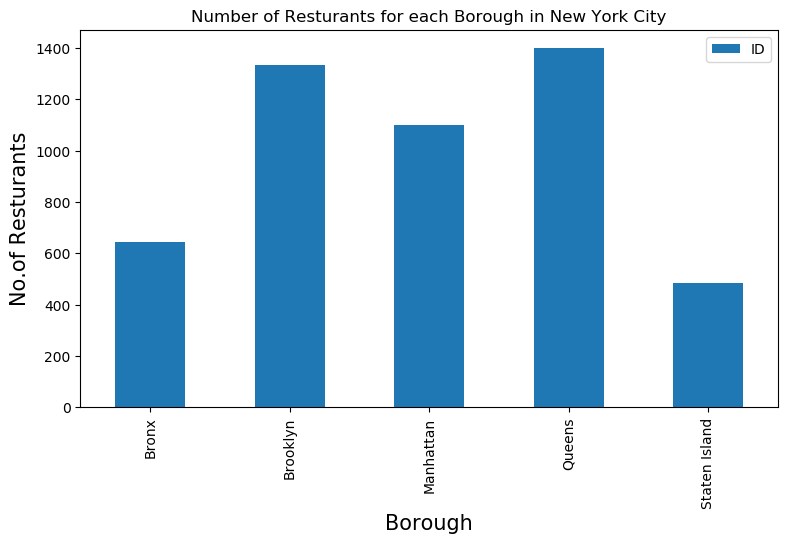

In [26]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Resturants', fontsize=15)
#giving a bar plot
rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

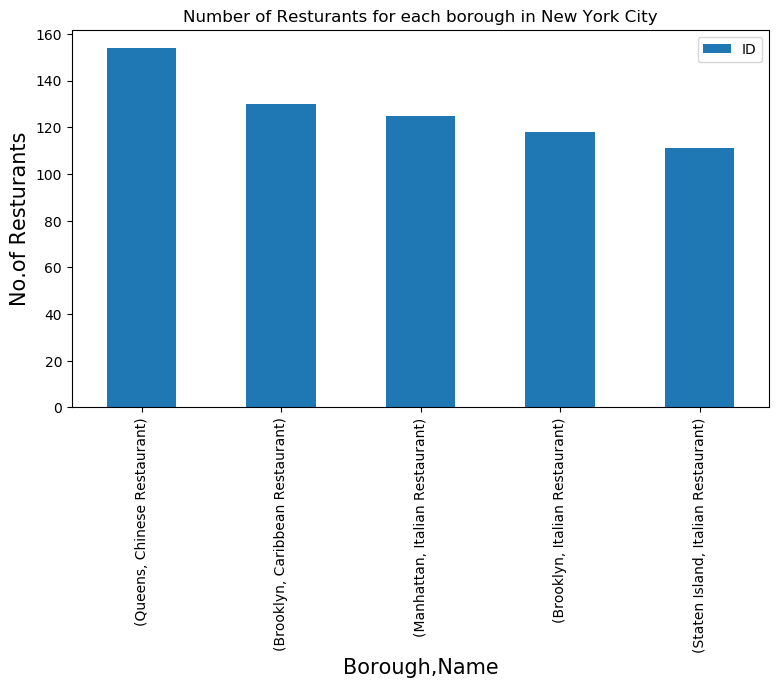

In [19]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Resturants for each borough in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Resturants', fontsize=15)
#giving a bar plot
rest_ny.groupby(['Borough','Name'])['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

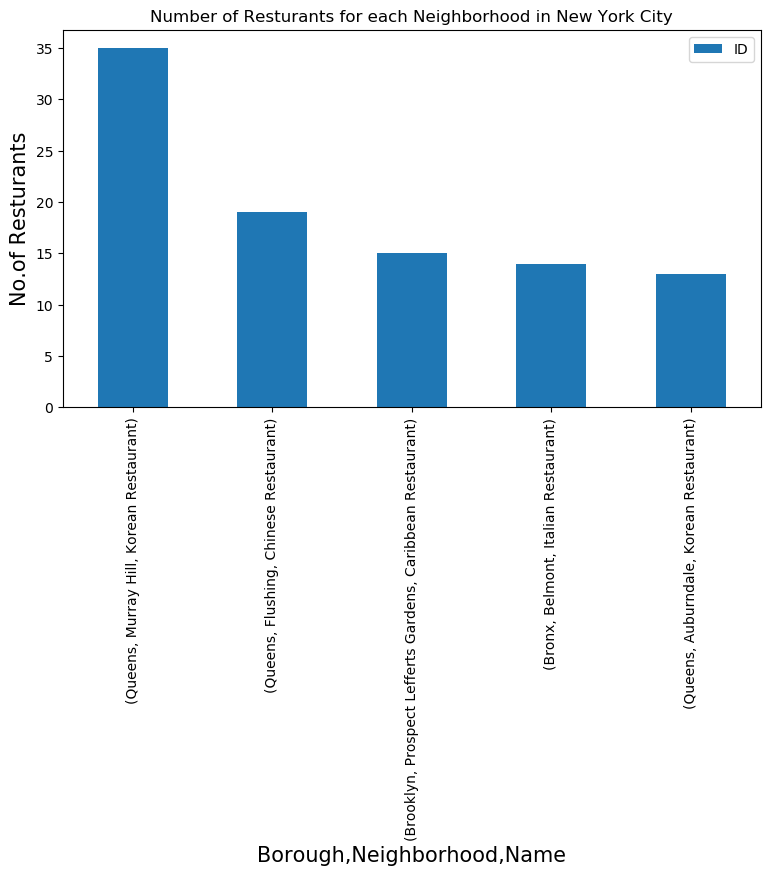

In [20]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Resturants', fontsize=15)
#giving a bar plot
rest_ny.groupby(['Borough','Neighborhood','Name'])['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [21]:
#rest_ny[rest_ny['Neighborhood']=='Murray Hill']

In [13]:
# prepare neighborhood list that contains resturants
column_names=['Borough', 'Neighborhood', 'Category', 'ID','Name','Likes','Rating','Tips']
rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name,Category=row
    try:
        print(ID)
        venue_details=get_venue_details(ID)
        time.sleep(1)
        #print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    except:
        print('Exception occured')
        continue
        
    print('(',count,'/',len(rest_ny),')','processed')
    rest_stats_ny = rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'Category' : category,  
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

From above we can see that there are 306 total different Neighborhoods in New York City in 5 boroughs.
Queens has highes number of neighborhoods - 81
Manhattan has - 40
Bronx has - 52
Brooklyn has - 70
Staten Island - 63

Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63

Restaurants
==========
Bronx             646
Brooklyn         1332
Manhattan        1100
Queens           1400
Staten Island     483





In [23]:
# of restaurants per neighborhood in each borough

print('In Bronx # of restaurants per neighborhood', 646/52)
print('In Brooklyn # of restaurants per neighborhood', 1332/70)
print('In Manhattan # of restaurants per neighborhood', 1100/40)
print('In Queens # of restaurants per neighborhood', 1400/81)
print('In Staten Island # of restaurants per neighborhood', 483/63)




In Bronx # of restaurants per neighborhood 12.423076923076923
In Brooklyn # of restaurants per neighborhood 19.02857142857143
In Manhattan # of restaurants per neighborhood 27.5
In Queens # of restaurants per neighborhood 17.28395061728395
In Staten Island # of restaurants per neighborhood 7.666666666666667


### This indicates that Staten Island has the least # of restaurants per neighborhood.

Now lets determine which category restaurant is well suited to start in Staten Island

In [ ]:
rest_ny.groupby('Borough')['ID'].count()

In [69]:
column_names=['Borough', 'Neighborhood', 'Category', 'ID','Name','Likes','Rating','Tips']
rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name,Category=row
    try:
        print(ID)
        venue_details=get_venue_details(ID)
        time.sleep(1)
        #print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    except:
        print('Exception occured')
        continue
        
    print('(',count,'/',len(rest_ny),')','processed')
    rest_stats_ny = rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'Category' : Category,  
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [68]:
rest_stats_ny.to_csv('Borough_Restaurant_Ratings.csv')

In [28]:
rest_stats_ny.head()

,Borough,Neighborhood,Category,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,Caribbean Restaurant,4d375ce799fe8eec99fd2355,Ripe Kitchen & Bar,70,8.7,33
1,Bronx,Wakefield,Caribbean Restaurant,4c9e50e38afca09379b2ff15,Ali's Roti Shop,16,8.5,9
2,Bronx,Wakefield,Caribbean Restaurant,4c10f6aece57c92804a682d2,Jackie's West Indian Bakery,22,7.8,13
3,Bronx,Wakefield,Caribbean Restaurant,508af256e4b0578944c87392,Cooler Runnings Jamaican Restaurant Inc,7,6.9,4
4,Bronx,Wakefield,Southern / Soul Food Restaurant,55bff8a5498e67af2457ca92,Paula's Soul Cafe,5,6.8,1


In [30]:
rest_stats_ny.groupby(['Borough','Category'])['ID'].count()

Borough    Category                       
Bronx      African Restaurant                  4
           American Restaurant                30
           Arepa Restaurant                    2
           Asian Restaurant                   13
           Caribbean Restaurant               32
           Chinese Restaurant                 50
           Cuban Restaurant                    2
           Dumpling Restaurant                 1
           Eastern European Restaurant         1
           Empanada Restaurant                 1
           Fast Food Restaurant               75
           French Restaurant                   1
           Greek Restaurant                    3
           Halal Restaurant                    1
           Indian Restaurant                   3
           Italian Restaurant                 74
           Japanese Restaurant                 8
           Latin American Restaurant          32
           Mexican Restaurant                 52
           Middle Eastern 

In [32]:
rest_stats_ny.groupby(['Borough','Category'])['Rating'].sum()

Borough    Category                       
Bronx      African Restaurant                  30.2
           American Restaurant                192.4
           Arepa Restaurant                    18.2
           Asian Restaurant                    82.0
           Caribbean Restaurant               229.6
           Chinese Restaurant                 112.6
           Cuban Restaurant                     8.8
           Dumpling Restaurant                  8.1
           Eastern European Restaurant          6.2
           Empanada Restaurant                  7.2
           Fast Food Restaurant               428.1
           French Restaurant                    7.6
           Greek Restaurant                    24.6
           Halal Restaurant                     0.0
           Indian Restaurant                   20.4
           Italian Restaurant                 539.5
           Japanese Restaurant                 61.3
           Latin American Restaurant          174.0
           Mexican Re

In [48]:
rest_stats_ny_avg = rest_stats_ny.groupby(['Borough','Category']).mean()[['Rating']]

In [49]:
rest_stats_ny_avg.head()

Rating
Borough Category                      
Bronx   African Restaurant    7.550000
        American Restaurant   6.413333
        Arepa Restaurant      9.100000
        Asian Restaurant      6.307692
        Caribbean Restaurant  7.175000

### Basing on below Arepa Restaurants or South American restaurant is a good option to start in Bronx

In [50]:
rest_stats_ny_avg.sort_values(['Rating'],ascending=False).head(10)

Rating
Borough   Category                           
Bronx     Arepa Restaurant           9.100000
          Tapas Restaurant           9.000000
          Peruvian Restaurant        8.800000
Manhattan Caribbean Restaurant       8.600000
Bronx     Greek Restaurant           8.200000
Manhattan Mexican Restaurant         8.133333
Bronx     Dumpling Restaurant        8.100000
          Vietnamese Restaurant      7.800000
          Middle Eastern Restaurant  7.800000
          Theme Restaurant           7.700000

In [52]:
ny_neighborhood_stats=pd.merge(rest_stats_ny_avg,new_york_data, on='Borough')


In [53]:
ny_neighborhood_stats.head()

,Borough,Rating,Neighborhood,Latitude,Longitude
0,Bronx,7.55,Wakefield,40.894705,-73.847201
1,Bronx,7.55,Co-op City,40.874294,-73.829939
2,Bronx,7.55,Eastchester,40.887556,-73.827806
3,Bronx,7.55,Fieldston,40.895437,-73.905643
4,Bronx,7.55,Riverdale,40.890834,-73.912585


In [54]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)


In [55]:
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

In [57]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Rating'].map(str)+')'


In [71]:
#for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

### Conclusion
Manhattan has more # of restaurants per neighborhood.
Queens has the highest restaurants in a neighborhood (Korean)
Staten Island has least number of restaurants


### Limitations
The ranking is purely on basis of rating of resturants
The accuracy of data depends purely depends on the data provided by FourSquare
Foursquare limitation of retrieving restaurant details 